## **Práctica final: Machine Learning: Modelos Supervisados**

Esta práctica ha sido realizada porSofía Rosón, Lucia Blanco y Paula Olalla. 

In [84]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from  sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from IPython.core.display import HTML 

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NCDB_1999_to_2014.csv")
data.shape

(5860405, 22)

DEFINICIÓN DE MODELOS SUPERVISADOS, obejtivo y describir el data 

¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

 ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones). 

Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc. 

## **1. Análisis de los datos y tratamiento de la variable objetivo**

En primer lugar importamos los datos. El dataset usado será obtenido de: https://www.kaggle.com/datasets/tbsteal/canadian-car-accidents-19942014?select=drivingLegend.pdf

In [87]:
data.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3




El dataset con el que vamos a trabajar trata información que hace referencia a los accidentes de tráfico en Canada desde 1999 hasta 2014. Vemos que la información se compone de datos sobre las personas relacionadas con el accidente (P_), datos relativos al accidente (C_) y por último, datos relativos al vehículo involucrado (V_).

La leyenda y significado de cada una de las variables se encuentra, en la carpeta Information del repositorio, bajo el nombre drivingLegend. La primera página incluye un pequeño resumen del dataset (Canadian Car Accidents) y de sus variables, y en el resto del documento, explica en detalle información sobre cada una de ellas.


    C_YEAR: Year,
    C_MNTH: Month,
    C_WDAY: Day of week,
    C_HOUR: Collision hour,
    C_SEV: Collision severity,
    C_VEHS: Number of vehicles involved in collision,
    C_CONF: Collision configuration,
    C_RCFG: Roadway configuration,
    C_WTHR: Weather condition,
    C_RSUR: Road surface,
    C_RALN: Road alignment,
    C_TRAF: Traffic control,
    V_ID: Vehicle sequence number,
    V_TYPE: Vehicle type,
    V_YEAR: Vehicle model year,
    P_ID: Person sequence number,
    P_SEX: Person sex,
    P_AGE: Person age,
    P_PSN: Person position,
    P_ISEV: Medical treatment required,
    P_SAFE: Safety device used,
    P_USER: Road user class

En general: UU/U: Unknown; XX/X: Jurisdiction does not provide this data; QQ/Q: Choice is other than the preceding values; NN: data element nos applicable


In [88]:
data

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,U,UU,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,U,18,1,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,4,18,1,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,Q,18,1,22,UUUU,01,M,67,12,3,01,U


Vemos la composición del dataframe, que cuenta con 22 variables y 5860405 registros. 

Las variables que eliminaremos serán passenger_id, y vehicle_id, que son variables identificativas; y la variable passenger_fatality, que nos indica si en el accidente hay lesión, muerte, o ninguna de las dos. La eliminamos ya que contamos con la variable "fatality", que ya nos indica si hay o no hay muertes en el accidente.

In [89]:
from pandas.core.describe import describe_categorical_1d
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "collision_config", "roadway_config", "weather",
"surface_state", "road_alignment", "traffic", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_position", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(data.columns))
data.columns = new_names

print(data.shape)
data1 = data.drop_duplicates().drop(['passenger_id','vehicle_id','passenger_fatality'], axis=1)
data1.shape

True
(5860405, 22)


(5855336, 19)

In [90]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5855336 entries, 0 to 5860404
Data columns (total 19 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   year                int64 
 1   month               object
 2   weekday             object
 3   hour                object
 4   fatality            int64 
 5   vehicles_involved   object
 6   collision_config    object
 7   roadway_config      object
 8   weather             object
 9   surface_state       object
 10  road_alignment      object
 11  traffic             object
 12  vehicle_type        object
 13  vehicle_year        object
 14  passenger_sex       object
 15  passenger_age       object
 16  passenger_position  object
 17  passenger_safety    object
 18  passenger_type      object
dtypes: int64(2), object(17)
memory usage: 893.5+ MB


## **Análisis de la variable objetivo**

In [91]:
data1['fatality'].unique()

array([2, 1])

In [92]:
fatality = data1['fatality']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

In [93]:
fatality

,index,percent
0,2,98.315793
1,1,1.684207


In [94]:
fat_count = data1['fatality'].value_counts().reset_index()
fatality1 = pd.merge(fatality, fat_count, on=['index'], how='inner')
fatality1

,index,percent,fatality
0,2,98.315793,5756720
1,1,1.684207,98616


La variable objetivo está compuesta por 1 y 2. El 1 nos indica que en el accidente han tenido lugar uno o más fallecimientos, y el 2 que no existen fallecimientos en el accidente.

Vamos a cambiar los valores por 1 y 0. De esta manera, 0 significará que hay fallecimiento en el accidente, y 1 que no lo hay.

Vemos una tabla simple que nos indica la proporción de fallecimientos en los accidentes, junto con un gráfico. Estos nos indican que en más del 98% de accidentes registrados no fallecen pasajeros. Posteriormente, se balanceará la variable objetivo para que la aplicación de algoritmos sea más adecuada.

In [95]:
import plotly.express as px

In [96]:
fig = px.histogram(fatality1, x="index", y=['percent'])
fig.show()

Antes de comenzar con el entrenamiento y validación de los modelos, observamos como se distribuye la variable objetivo. C_SEV nos indica la gravedad de la colisión, de forma que los accidentes con un valor 1 en esta columna son aquellos en los cuales al menos se ha producido una muerte, mientras que los accidentes que toman el valor 2 no son mortales. Observamos que la gran mayoría (98,32%) de accidentes no han sido mortales frente al 1,68% de accidentes mortales.

In [97]:
data1['fatality'] = data1['fatality'].replace({1: 0, 2: 1})
data1

,year,month,weekday,hour,fatality,vehicles_involved,collision_config,roadway_config,weather,surface_state,road_alignment,traffic,vehicle_type,vehicle_year,passenger_sex,passenger_age,passenger_position,passenger_safety,passenger_type
0,1999,1,1,20,1,02,34,UU,1,5,3,03,06,1990,M,41,11,UU,1
1,1999,1,1,20,1,02,34,UU,1,5,3,03,01,1987,M,19,11,UU,1
2,1999,1,1,20,1,02,34,UU,1,5,3,03,01,1987,F,20,13,02,2
3,1999,1,1,08,1,01,01,UU,5,3,6,18,01,1986,M,46,11,UU,1
4,1999,1,1,08,1,01,01,UU,5,3,6,18,NN,NNNN,M,05,99,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,1,UU,UU,01,U,U,U,UU,07,UUUU,M,24,11,NN,1
5860401,2014,UU,U,23,1,01,06,05,1,1,U,18,14,2006,M,29,96,09,5
5860402,2014,UU,U,14,1,01,02,01,1,5,4,18,01,2006,F,UU,11,01,1
5860403,2014,UU,U,22,0,01,06,01,2,4,Q,18,22,UUUU,M,67,12,01,U


**Valores nulos**

In [98]:
data1.isnull().sum()

year                  0
month                 0
weekday               0
hour                  0
fatality              0
vehicles_involved     3
collision_config      0
roadway_config        0
weather               0
surface_state         0
road_alignment        0
traffic               0
vehicle_type          0
vehicle_year          0
passenger_sex         0
passenger_age         0
passenger_position    0
passenger_safety      0
passenger_type        0
dtype: int64

En referencia al número de NA's en todo el conjunto de datos, vemos que simplemente hay 3 datos faltantes en la columna C_VEHS, asi que simplemente procedemos a eliminarlos, ya que consideramos que no afectarán al dataset general.

In [99]:
data1 = data1.dropna()

Se observa que esta base de datos cuenta con muy pocos valores nulos. Por lo tanto, analizaremos el tipo de valor. 

In [100]:
data1.dtypes

year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
collision_config      object
roadway_config        object
weather               object
surface_state         object
road_alignment        object
traffic               object
vehicle_type          object
vehicle_year          object
passenger_sex         object
passenger_age         object
passenger_position    object
passenger_safety      object
passenger_type        object
dtype: object

Vemos que hay mayoría son valores object porque cuentan con variables categoricas. 

# **Transformación de variables**

A continuación, analizaremos los valores desconocidos.

Como hemos podido ver antes, y como podemos leer en la leyenda de los datos, encontramos una serie de valores desconocidos o unknown values:

    U/UU/UUU : Datos estrictamente desconocidos
    X/XX/XXX : No se ha proporcionado el dato.
    Q/QQ/QQQ : La elección es distinta de los valores anteriores. 
    N/NN/NNN : La variable no aplica al registro. 

Todos ellos suponen información faltante, asi, procederemos a reemplazarlos por valores outliers para no alterar el dataset.

In [101]:
#Reemplazamos las Us, Xs y Ns por NAS.
data1 = data1.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan, "X": np.nan, "XX": np.nan, "XXXX": np.nan, "N": np.nan, "NN": np.nan, "NNNN": np.nan})
#Reemplazamos las Qs por ceros.
data1 = data1.replace({"Q": 0, "QQ": 0, "QQQQ": 0})

In [102]:
#Distribución de los NA's por columnas
pd_series_null_columns = data1.isnull().sum().sort_values(ascending=False)
pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_por_columnas'])     
pd_null_columnas['porcentaje_nulos_por_columnas'] = pd_null_columnas['nulos_por_columnas']/data1.shape[0]
pd_null_columnas

,nulos_por_columnas,porcentaje_nulos_por_columnas
passenger_safety,1185905,0.202534
vehicle_year,583175,0.099597
roadway_config,504546,0.086169
road_alignment,434626,0.074227
passenger_age,394235,0.067329
vehicle_type,257268,0.043937
passenger_sex,249131,0.042548
traffic,223448,0.038161
collision_config,178785,0.030534
passenger_type,175455,0.029965


In [103]:
#Distribución de los NA's por filas
pd_series_null_rows = data1.isnull().sum(axis=1).sort_values(ascending=False)
pd_null_rows = pd.DataFrame(pd_series_null_rows, columns=['nulos_por_filas'])  
pd_null_rows['porcentaje_nulos_por_filas']= pd_null_rows['nulos_por_filas']/data1.shape[1]
pd_null_rows

,nulos_por_filas,porcentaje_nulos_por_filas
5245711,16,0.842105
5245712,16,0.842105
835560,15,0.789474
3226045,15,0.789474
3226040,15,0.789474
...,...,...
3337069,0,0.000000
3337070,0,0.000000
1687765,0,0.000000
573479,0,0.000000


## **Filas repetidas**

  Al analizar las columnas y variables del dataset, podemos concluir a priori, que cada fila no representa un accidente diferente, si no que se desglosan en ella, las personas y vehiculos implicados. Para responder a algunas de las cuestiones y predecir ciertos datos, este hecho es de gran importancia, pues solo habria que tener en cuenta el número total de accidente

Asi, a continuación, también es importante analizar la existencia de filas repetidas, y si fueran una cifra considerada, proceder a eliminarlas.

In [104]:
data1[data1.duplicated(keep = 'first')]


,year,month,weekday,hour,fatality,vehicles_involved,collision_config,roadway_config,weather,surface_state,road_alignment,traffic,vehicle_type,vehicle_year,passenger_sex,passenger_age,passenger_position,passenger_safety,passenger_type
106,1999,1,1,14,1,06,0,NaN,1,2,1,NaN,06,1993,NaN,NaN,11,NaN,1
763,1999,1,1,07,1,02,31,01,2,5,4,NaN,09,1997,NaN,NaN,21,13,2
765,1999,1,1,07,1,02,31,01,2,5,4,NaN,09,1997,NaN,NaN,23,13,2
879,1999,1,1,10,1,02,24,01,1,3,3,18,06,1997,NaN,NaN,98,02,NaN
1185,1999,1,1,12,1,01,01,03,1,2,1,18,NaN,NaN,F,13,99,13,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860385,2014,NaN,NaN,NaN,1,NaN,NaN,01,NaN,NaN,NaN,NaN,NaN,2000,NaN,NaN,NaN,NaN,NaN
5860386,2014,NaN,NaN,NaN,1,NaN,NaN,01,NaN,NaN,NaN,NaN,NaN,2000,NaN,NaN,NaN,NaN,NaN
5860387,2014,NaN,NaN,NaN,1,NaN,NaN,01,NaN,NaN,NaN,NaN,NaN,2000,NaN,NaN,NaN,NaN,NaN
5860388,2014,NaN,NaN,NaN,1,NaN,NaN,01,NaN,NaN,NaN,NaN,NaN,2000,NaN,NaN,NaN,NaN,NaN


# **Transformación de variables a númericas (object)**

In [105]:
data1.passenger_sex.replace({"M":1, "F":0}, inplace=True)

for column in data1.columns:
  data1[column] = pd.to_numeric(data1[column], errors = 'ignore', downcast= 'integer')

In [106]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5855333 entries, 0 to 5860404
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   year                int16  
 1   month               float64
 2   weekday             float64
 3   hour                float64
 4   fatality            int8   
 5   vehicles_involved   float64
 6   collision_config    float64
 7   roadway_config      float64
 8   weather             float64
 9   surface_state       float64
 10  road_alignment      float64
 11  traffic             float64
 12  vehicle_type        float64
 13  vehicle_year        float64
 14  passenger_sex       float64
 15  passenger_age       float64
 16  passenger_position  float64
 17  passenger_safety    float64
 18  passenger_type      float64
dtypes: float64(17), int16(1), int8(1)
memory usage: 820.9 MB


## **3. Análisis exploratorio**

In [107]:
df_eda = data1.dropna()

### 3.1Serie temporal accidentes 

In [108]:
fatality_1 = pd.DataFrame(df_eda.loc[data1.fatality == 1].groupby('year')['fatality'].count())
fatality_0 = pd.DataFrame(df_eda.loc[data1.fatality == 0].groupby('year')['fatality'].count())
fatality_ts = pd.concat([fatality_1, fatality_0.reindex(fatality_1.index)], axis=1)
fatality_ts.columns = ['fatal_accidents', 'non_fatal_accidents']
fatality_ts = fatality_ts.rename_axis('year').reset_index()

fatality_ts

,year,fatal_accidents,non_fatal_accidents
0,1999,237023,4638
1,2000,254578,4151
2,2001,247063,4378
3,2002,254799,4581
4,2003,248006,4477
5,2004,238365,4597
6,2005,235974,4587
7,2006,228170,4527
8,2007,221310,4093
9,2008,203925,3468


Creamos un dataframe en el que se recoge el número de accidentes de cada año, distinguiendo entre accidentes mortales y no mortales.

En el gráfico que vemos a continuación, se nos muestra la evolución de los accidentes, donde podemos ver que a lo largo de los años, los accidentes mortales se reducen a casi la mitad en 15 años. Además, vemos que en esos 15 años, hay una diferencia de más de 50.000 accidentes entre 1999 y 2014.

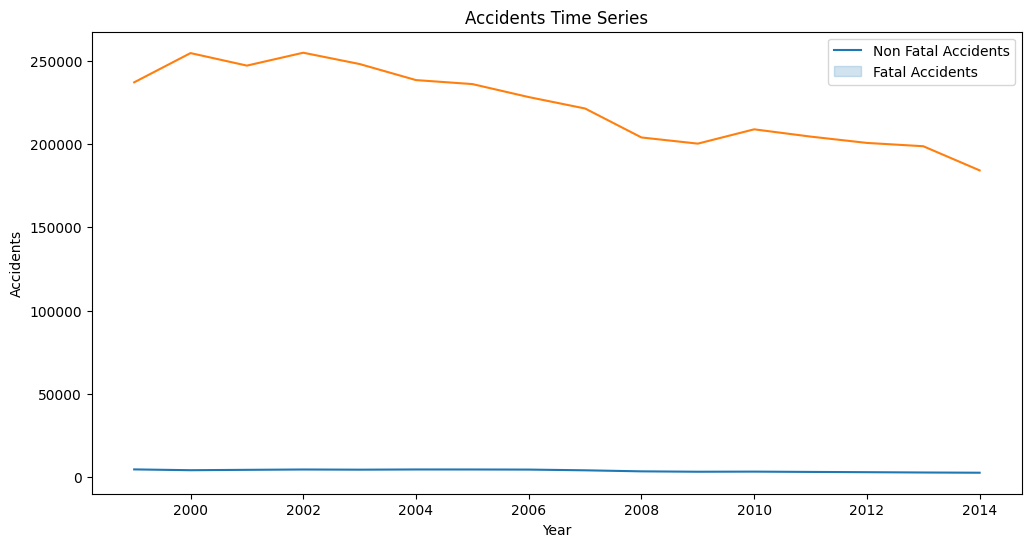

In [109]:
plt.figure(figsize = (12,6))
sns.lineplot(x = 'year', y = 'non_fatal_accidents', data = fatality_ts)
sns.lineplot(x = 'year', y = 'fatal_accidents', data = fatality_ts)
plt.title("Accidents Time Series")
plt.xlabel("Year")
plt.ylabel("Accidents")
plt.legend(labels=["Non Fatal Accidents","Fatal Accidents"])

**3.2 Frecuencia de accidentes por tipo de vehiculo**

In [110]:
#¿Qué tipos de vehículos son más propensos a sufrir accidentes?
vehicle_type = df_eda.groupby(['vehicle_type'])['vehicle_type'].count()
v_acc = pd.DataFrame(vehicle_type)
v_acc = v_acc.set_axis(['count'], axis=1, inplace=False)
v_acc = v_acc.reset_index(level=0)
v_acc['percentage'] = v_acc['count']/sum(v_acc['count'])
v_acc = v_acc.sort_values(by=['percentage'], ascending=False)

v_acc

,vehicle_type,count,percentage
0,1.0,3272478,0.902083
2,6.0,112267,0.030947
8,14.0,58283,0.016066
3,7.0,46537,0.012828
1,5.0,44562,0.012284
4,8.0,41346,0.011397
7,11.0,31169,0.008592
5,9.0,13393,0.003692
9,17.0,3038,0.000837
10,18.0,1699,0.000468


En el dataframe anterior vemos la cantidad de accidentes en función del tipo de vehículo, representados en un gráfico de barras a continuación. Vemos que el 90% de los accidentes llevan el número 1, que se corresponde con coches de pasajeros, furgonetas de pasajeros, o pick-ups.

En segundo lugar podemos ver que el siguiente vehículo con más accidentes es el número 6, que se corresponde con otros camiones y furgonetas, y se encuentran en el 3% de los accidentes; seguidos de las motocicletas y motocicletas de velocidad limitada (número 14), que se encuentran en un 1% de los accidentes, al igual que vehículos como las furgonetas de transporte de materiales, los camiones más pesados, y tractores.

<Axes: xlabel='vehicle_type', ylabel='percentage'>

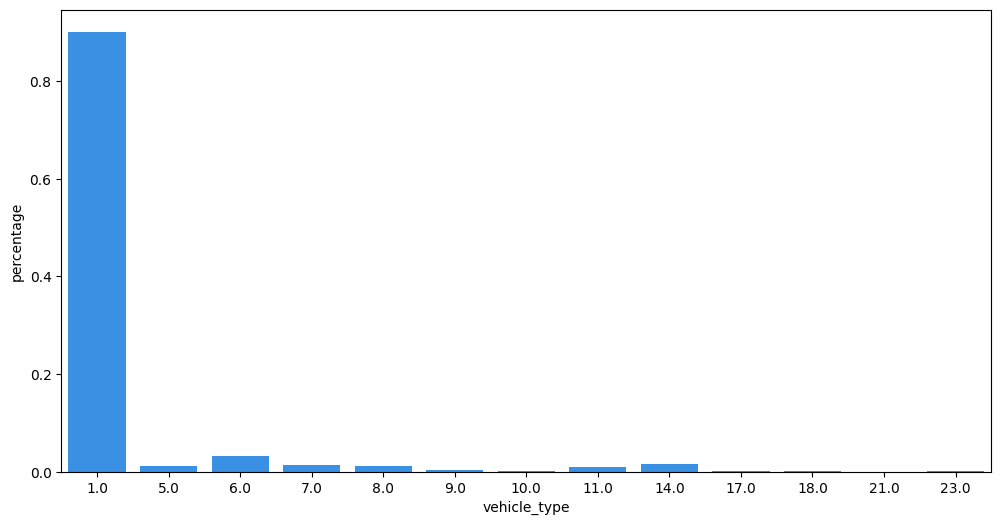

In [111]:
plt.figure(figsize = (12,6))
sns.barplot(data = v_acc, x = 'vehicle_type', y = 'percentage', color = 'dodgerblue')

In [112]:
df_eda['vehicle_age'] = df_eda['year'] - df_eda['vehicle_year']

# **3.3 Accidentes por meses**

In [113]:
month_fatality = pd.DataFrame(df_eda.loc[df_eda.fatality == 1].groupby(['month'])['fatality'].count())
month_fatality = month_fatality.reset_index()
month_fatality.columns = ['month', 'total_accidents']
month_fatality

,month,total_accidents
0,1.0,310252
1,2.0,263727
2,3.0,253266
3,4.0,241586
4,5.0,285056
5,6.0,313280
6,7.0,321701
7,8.0,327434
8,9.0,304603
9,10.0,313124


In [114]:
month_fatality['total_accidents'].mean()

297178.9166666667

En el siguiente gráfico vemos el número de accidentes por mes, y podemos ver claramente que estos se incrementan a partir del mes de mayo, pasando de menos de 5000 accidentes en mayo, a más de 6000 en los meses de julio y agosto.

Podemos decir que esto se debe a que en los meses de verano tienen lugar más viajes, al igual que en el mes de diciembre, correspondiéndose con las vacaciones de Navidad. Todos estos meses superan notablemente la media.

Text(0, 0.5, 'Accidents')

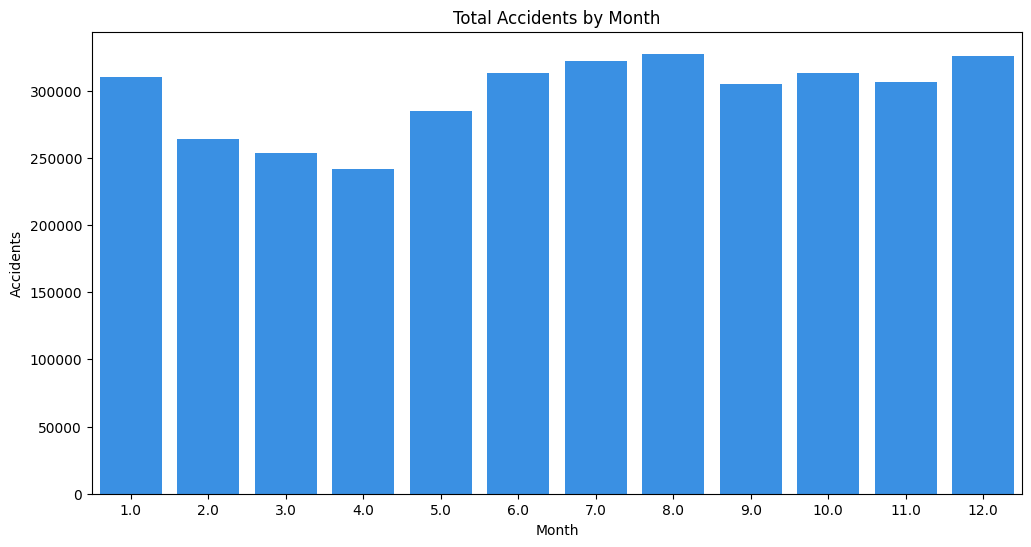

In [115]:
plt.figure(figsize = (12,6))
sns.barplot(x = month_fatality['month'], y = month_fatality['total_accidents'], color = 'dodgerblue')
plt.title("Total Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Accidents")

# **3.4 Accidentes por días de la semana**

In [116]:
weekday_fatality = pd.DataFrame(df_eda.groupby(['weekday'])['fatality'].count())
weekday_fatality = weekday_fatality.reset_index()
weekday_fatality.columns = ['weekday', 'total_accidents']
weekday_fatality

,weekday,total_accidents
0,1.0,478078
1,2.0,500853
2,3.0,503622
3,4.0,532203
4,5.0,616935
5,6.0,547386
6,7.0,448613


Respecto a los accidentes según los días de la semana, podemos ver que los días en los que más accidentes se producen son el viernes y el sábado. Esto se debe a que son los días en los que hay una mayor movilidad en las carreteras, principalmente porque es cuando las personas hacen planes relacionados con su tiempo libre.

Text(0, 0.5, 'Accidents')

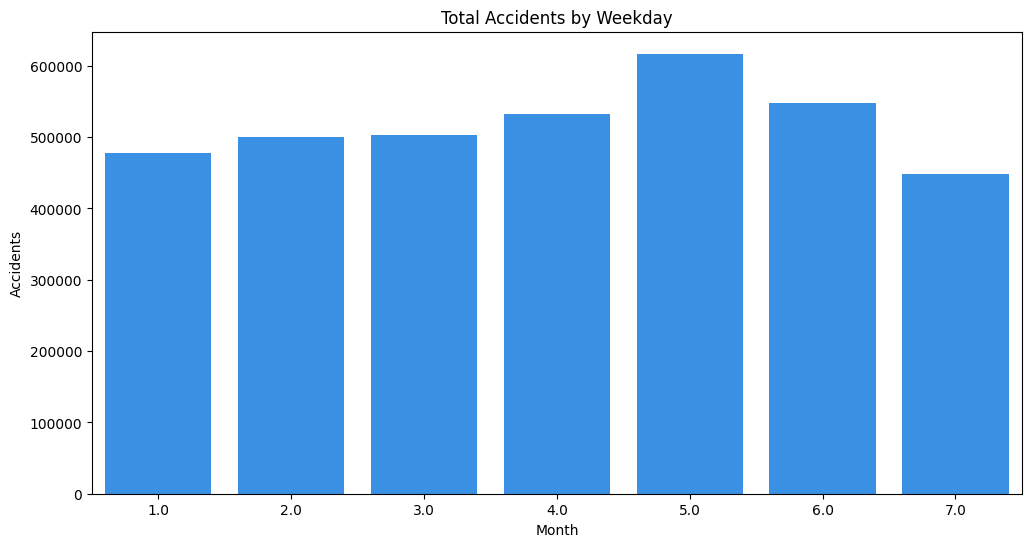

In [117]:
plt.figure(figsize = (12,6))
sns.barplot(x = weekday_fatality['weekday'], y = weekday_fatality['total_accidents'], color = 'dodgerblue')
plt.title("Total Accidents by Weekday")
plt.xlabel("Month")
plt.ylabel("Accidents")

In [118]:
df_eda.groupby(['fatality'])['fatality'].count()

fatality
0      61543
1    3566147
Name: fatality, dtype: int64

# **3.5 Accidentes según clima**

In [119]:
weather_fatality = pd.DataFrame(df_eda.groupby(['weather'])['fatality'].count())
weather_fatality = weather_fatality.reset_index()
weather_fatality.columns = ['weather', 'total_accidents']
weather_fatality

,weather,total_accidents
0,0.0,7476
1,1.0,2542398
2,2.0,351693
3,3.0,401504
4,4.0,238792
5,5.0,20051
6,6.0,55622
7,7.0,10154


Respecto al clima, los días en los que más accidentes se producen, se tratan de los días soleados. Esto nos muestra que no existe ninguna dependencia entre la presencia de precipitaciones en forma de nieve o lluvia y el número de accidentes, al igual que tampoco existe con los días con niebla o viento fuerte.

Text(0, 0.5, 'Total Accidents')

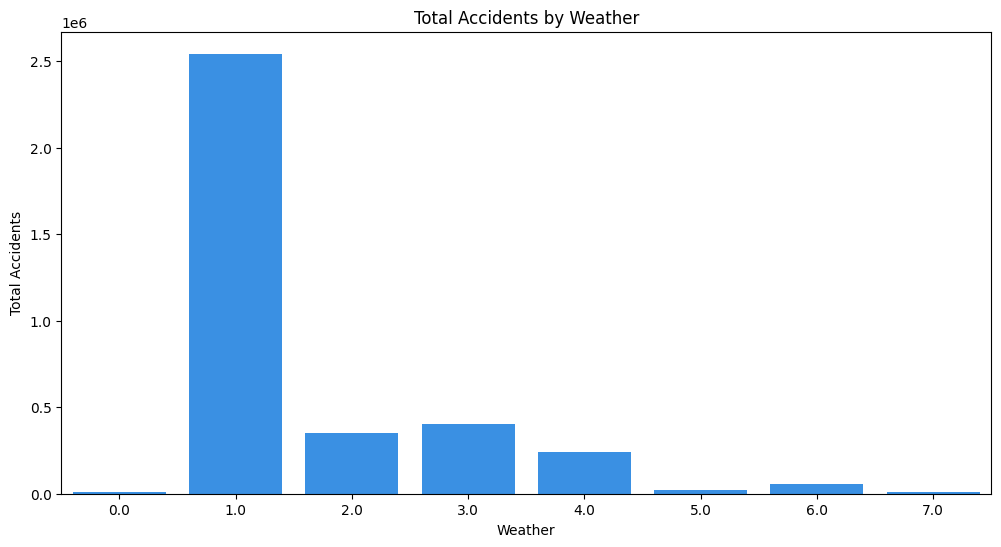

In [120]:
plt.figure(figsize = (12,6))
sns.barplot(x = weather_fatality['weather'], y = weather_fatality['total_accidents'], color = 'dodgerblue')
plt.title("Total Accidents by Weather")
plt.xlabel("Weather")
plt.ylabel("Total Accidents")


# **Accidentes por sexo**

In [121]:
sex_fatality = pd.DataFrame(df_eda.groupby('passenger_sex')['fatality'].count())
sex_fatality = sex_fatality.reset_index()
sex_fatality.columns = ['sex', 'total_accidents']
sex_fatality

,sex,total_accidents
0,0.0,1667920
1,1.0,1959770


Respecto a la distribución de los accidentes por sexo, son los hombres (1), los que más accidentes tienen, superando en casi 300.000 ocasiones a las mujeres.

Text(0, 0.5, 'Total Accidents')

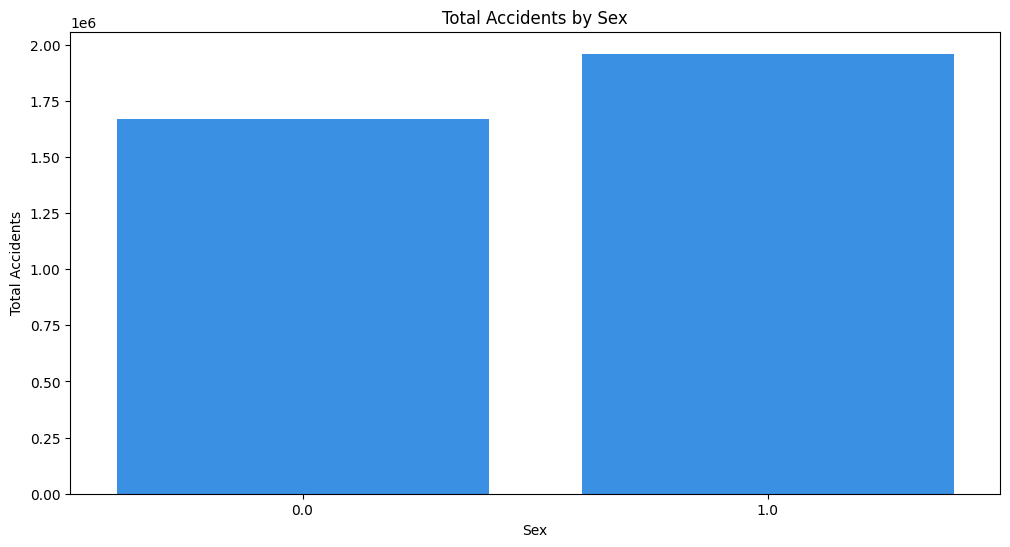

In [122]:
plt.figure(figsize = (12,6))
sns.barplot(x = sex_fatality['sex'], y = sex_fatality['total_accidents'], color = 'dodgerblue')
plt.title("Total Accidents by Sex")
plt.xlabel("Sex")
plt.ylabel("Total Accidents")

# **Accidentes por edad**

In [123]:
age_fatality = pd.DataFrame(df_eda.groupby('passenger_age')['fatality'].count())
age_fatality = age_fatality.reset_index()
age_fatality.columns = ['age', 'total_accidents']
age_fatality

,age,total_accidents
0,1.0,31671
1,2.0,19678
2,3.0,19780
3,4.0,20064
4,5.0,19904
5,6.0,18738
6,7.0,18798
7,8.0,18995
8,9.0,18995
9,10.0,19651


Realizamos una agrupación por edad y un conteo de los accidentes. Como se puede apreciar en el siguiente gráfico, los conductores que experimentan accidentes con mayor frecuencia son aquellos que acaban de obtener su licencia de conducir, ya que en Canadá la edad mínima requerida son 16 años, esto puede deberse a multiples factores relevantes al perfil del accidentado como por ejemplo la poca experiencia al volante de los conductores primerizos o tambein a una personalidad menos precavida de los jovenes. Entre los 30 y los 45 años la frecuencia de los accidentes se mantiene relativamente estable y posteriormente se reduce progresivamente, ya que se conduce con mucha emnos frecuencia con la vejez ya que pierdes capacdades esenciales para la consuccion como puede ser la vista o los reflejos. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '11.0'),
  Text(11, 0, '12.0'),
  Text(12, 0, '13.0'),
  Text(13, 0, '14.0'),
  Text(14, 0, '15.0'),
  Text(15, 0, '16.0'),
  Text(16, 0, '17.0'),
  Text(17, 0, '18.0'),
  Text(18, 0, '19.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '21.0'),
  Text(21, 0, '22.0'),
  Text(22, 0, '23.0'),
  Text(23, 0, '24.0'),
  Text(24, 0, '25.0')

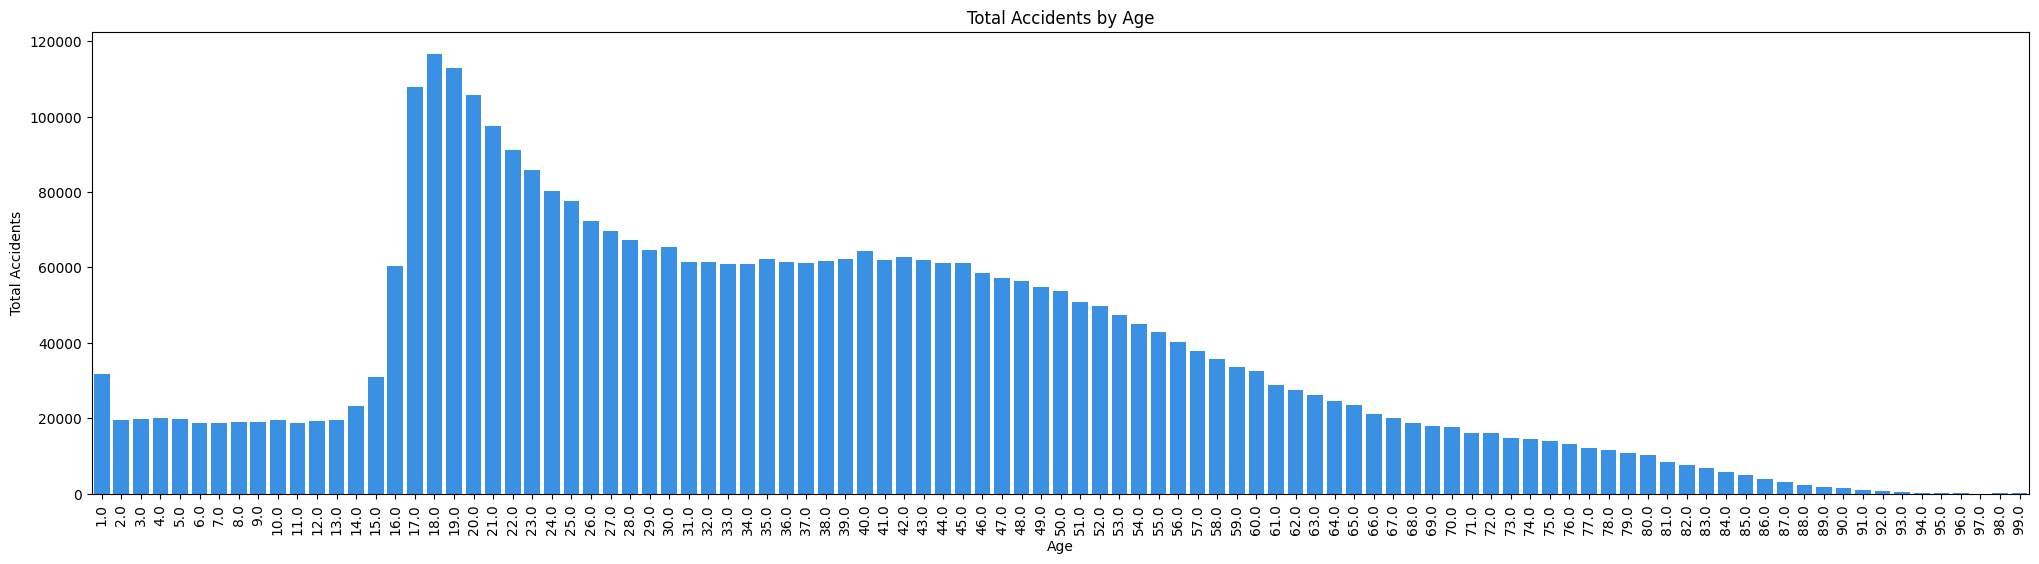

In [124]:
plt.figure(figsize = (25,6))
sns.barplot(x = age_fatality['age'], y = age_fatality['total_accidents'], color = 'dodgerblue')
plt.title("Total Accidents by Age")
plt.xlabel("Age")
plt.ylabel("Total Accidents")
plt.xticks(rotation=90)

Gracias ha este analisis exploratorio podemos concluir que segun los datos selccionados y estudiados en esta parte del trabajo, vemos como detallar un perfil modelo para indentificar los conductores mas propesos a sufrir accidentes con frecuencia. Como bien hemos comentado los hombres de entre las edades de 17 a 40 años con vehiculos de pasajeros, como coches de pasajeros o furgonatas con pasajeros o pick-ups. 

# **4.División en train y test y tratamiento de cada conjunto**

Antes de dividir los datos en train y test, seleccionamos una muestra aleatoria de 100.000 valores. Así mantenemos la estructura del dataset pero trabajamos con menos registros, lo que nos beneficia a la hora de aplicar algoritmos. Podemos ver que se mantiene la proporción de la variable objetivo

In [125]:
df_sample = data1.sample(n=100000)

df_sam = pd.DataFrame(df_sample.groupby(['fatality'])['fatality'].count().rename('Count'))
df_sam['Percentage'] = df_sam['Count']/df_sam['Count'].sum()
df_sam = df_sam.sort_values(by = "Count", ascending=False).reset_index()
df_sam

,fatality,Count,Percentage
0,1,98333,0.98333
1,0,1667,0.01667


# **4.2 Train y test**

Dividimos la muestra en train y test. Después, dividimos cada conjunto en x e y, siendo x los conjuntos con todas las variables excepto la variable objetivo, e y con ella. Les hemos quitado los valores nulos a cada conjunto para poder llevar a cabo la aplicación de algoritmos.

In [126]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_sample, test_size=0.2, stratify = df_sample['fatality'])

In [127]:
x_train = train.dropna().drop('fatality', axis = 1)
y_train = train.dropna()['fatality']
x_test = test.dropna().drop('fatality', axis = 1)
y_test = test.dropna()['fatality']

# **4.3 Tratamiento de train**

Tras dividir los datos en x_train, y_train, x_test e y_test, vamos a tratar los datos de entrenamiento. En primer lugar, vamos a balancear los datos. Después, como en y_train solo se encuentra la variable objetivo (fatality), la cual ya es numérica y no contiene NA's, procederemos a tratar únicamente los datos de x_train.

Creamos una variable que nos indica la antiguedad del vehículo en el momento del accidente, usando el año del vehículo y el del accidente. Esta variable se creará tanto en x_train como en x_test.

Además, balancearemos los datos de la variable objetivo para x_train e y_train. Esto lo hacemos dado que los accidentes sin mortalidad representan más del 95% de la muestra, lo que podría llevarnos a obtener resultados sesgados una vez apliquemos los algoritmos de clasificación. Para esto, utilizaremos la función Oversample, dejando la variable objetivo más balanceada, pero manteniendo la proporción de accidentes no mortales por encima de los accidentes mortales.

Por último, hemos cambiado las variables con tipo float a variables tipo integer, con el mismo bucle for que hemos usado anteriormente.

In [128]:
x_train['vehicle_age'] = x_train['year'] - x_train['vehicle_year'] 
x_test['vehicle_age'] = x_test['year'] - x_test['vehicle_year'] 


from collections import Counter
from imblearn.over_sampling import RandomOverSampler

oversample =  RandomOverSampler(sampling_strategy=0.6)
x_train_bal, y_train_bal = oversample.fit_resample(x_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_bal)))

Distribution of class labels before resampling Counter({1: 48605, 0: 824})
Distribution of class labels after resampling Counter({1: 48605, 0: 29163})


In [129]:
unique, counts = np.unique(y_train_bal, return_counts=True)
dict(zip(unique, counts))

{0: 29163, 1: 48605}

In [130]:
for column in x_train_bal.columns:
  x_train_bal[column] = pd.to_numeric(x_train_bal[column], errors = 'ignore', downcast= 'integer')

## **5. Aplicación de algoritmos: Clasificación de fallecimientos**


Objetivo

En este apartado generamos dos modelos que nos ayuden a predecir los fallecimientos y además, determinar si necesitarán tratamiento médico, para ello utilizamos los modelos de Regresión Logística y XGBoost, aunque hay más modelos que hemos estudiado en clase:

    Regresión Logística
    K-NN
    Arbol de decisión simple
    Bagging Classifier
    Random Forest
    Gradient Boost
    XGBoost

Y posteriormente los evaluamos en función de las métricas de:

    Accuracy
    Precision
    Recall
    Confusion Matrix
    F-score
    Curva ROC
    Area bajo la curva

Seleccionaremos el mejor modelo y analizaremos la importancia del resto de variables para ese modelo según el peso, ganancia y cover.

Tras este análisis responderemos a la pregunta planteada sobre el tratamiento médico y haremos una conclusión.


In [131]:
# Importamos las librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import seaborn as sb
import plotly.graph_objects as go
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score

# **5.1 Regresión logística**

In [132]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

In [133]:
objetivo = ["fatality"]

In [134]:
data1.dropna()

,year,month,weekday,hour,fatality,vehicles_involved,collision_config,roadway_config,weather,surface_state,road_alignment,traffic,vehicle_type,vehicle_year,passenger_sex,passenger_age,passenger_position,passenger_safety,passenger_type
44,1999,1.0,1.0,12.0,1,1.0,4.0,0.0,1.0,5.0,3.0,18.0,1.0,1993.0,0.0,25.0,11.0,2.0,1.0
45,1999,1.0,1.0,10.0,1,1.0,3.0,0.0,1.0,2.0,1.0,18.0,1.0,1998.0,1.0,65.0,11.0,2.0,1.0
46,1999,1.0,1.0,15.0,1,1.0,0.0,1.0,1.0,1.0,1.0,6.0,1.0,1995.0,1.0,17.0,11.0,2.0,1.0
48,1999,1.0,1.0,23.0,1,1.0,2.0,0.0,1.0,5.0,1.0,10.0,1.0,1997.0,1.0,25.0,11.0,2.0,1.0
52,1999,1.0,1.0,9.0,1,2.0,34.0,2.0,1.0,1.0,1.0,1.0,1.0,1992.0,0.0,33.0,11.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860376,2014,12.0,7.0,14.0,1,2.0,41.0,1.0,1.0,5.0,1.0,18.0,5.0,2008.0,1.0,44.0,11.0,2.0,1.0
5860377,2014,12.0,7.0,14.0,1,2.0,41.0,1.0,1.0,5.0,1.0,18.0,5.0,2008.0,1.0,34.0,13.0,2.0,2.0
5860378,2014,12.0,7.0,19.0,1,1.0,3.0,1.0,1.0,3.0,4.0,18.0,1.0,2001.0,0.0,35.0,11.0,2.0,1.0
5860379,2014,12.0,7.0,19.0,1,1.0,3.0,1.0,1.0,3.0,4.0,18.0,1.0,2001.0,1.0,26.0,13.0,2.0,2.0


In [135]:
df = data1.dropna()

In [136]:
X = df.drop(objetivo,axis=1)
Y = df[objetivo]

**CONJUNTO DE ENTRENAMIENTO**

In [137]:
# Division del dataset en entrenamiento y test
# proporcion 30 y 70
# utilizamos stratify para que los subconjuntos mantengan la proporción de las clases

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [138]:
# conjunto de entrenamiento (TRAIN)
print(x_train.shape)
# 4098733 filas

print(y_train["fatality"].value_counts()/sum(y_train["fatality"].value_counts())*100)
y_train.value_counts()



(2539383, 18)
1    98.305612
0     1.694388
Name: fatality, dtype: float64


fatality
1           2496356
0             43027
dtype: int64

In [139]:
# conjunto de validación (TEST)
x_test.shape
# 1758121 filas

print(y_test["fatality"].value_counts()/sum(y_test["fatality"].value_counts())*100)
y_test.value_counts()

1    98.298642
0     1.701358
Name: fatality, dtype: float64


fatality
1           1069791
0             18516
dtype: int64



Los conjuntos están desbalanceados dada la desproporcionada distribución de la variable objetivo en la base de datos original. Se mantiene la distribución de 1,68% de accidentes mortales frente a 98,32% de accidentes no mortales.


**MODELOS**

In [140]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

In [141]:
logit.fit(x_train, y_train)

LogisticRegression()

In [142]:
# ACCURACY
accuracy_score(y_train, logit.predict(x_train))

0.9830561203252917

La métrica de exactitud nos indica que el modelo es muy bueno, sin embargo hay que tener en cuenta que las clases están desbalanceadas, ya que predominan los casos en los que los accidentes no son mortales, y esta métrica es engañosa cuando esto sucede porque nos hace creer que el modelo es mejor de lo que en realidad es. Por eso, calculamos el resto de métricas para comparar.

In [143]:
# PRECISION
precision_score(y_train, logit.predict(x_train))

0.9830561203252917

In [144]:
# RECALL
recall_score(y_train, logit.predict(x_train))

1.0

In [145]:
# CONFUSION MATRIX
cm = confusion_matrix(y_train, logit.predict(x_train))
cm

array([[      0,   43027],
       [      0, 2496356]])

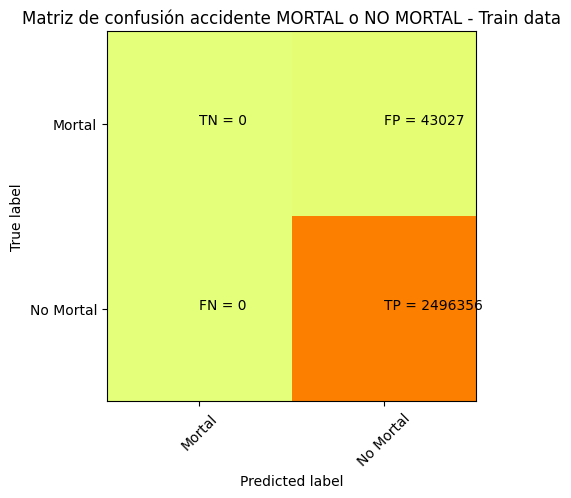

In [146]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - Train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Mediante la matriz de correlación se observa que mediante este modelo se predice mejor los True Negative (Verdaderos Negativos: aquellos accidentes que el modelo predice que son mortales y que en realidad son mortales) aunque el número de False Negative (Falso Negativos: aquellos accidentes que el modelo predice que no son mortales y en realidad son mortales). El objetivo de la predicción de los modelos es minimizar el total de Falsos Positivos y Falsos Negativos, que es lo mismo que maximizar los Verdaderos Negativos y Verdaderos Positivos.

In [147]:
# F1 SCORE
f1_score(y_train, logit.predict(x_train))

0.9914556731395333

In [148]:
# AREA BAJO LA CURVA
roc_auc_score(y_train, logit.predict(x_train))

0.5

El valor que obtenemos de área bajo la curva nos indica que el modelo no predice correctamente, hace predicciones aleatorias.

Una vez entrenado el modelo procedemos a validar los resultados entrenados para comprobar si obtenemos las mismas conclusiones:


**CONJUNTO TEST**

In [149]:
logit.fit(x_test, y_test)

LogisticRegression()

In [150]:
# ACCURACY
accuracy_score(y_test, logit.predict(x_test))

0.9829818240625118

Como ocurría en el conjunto de entrenamiento, la métrica de exactitud (Accuracy) nos indica que el modelo es muy bueno, aunque la realidad es lo contrario.

In [151]:
# PRECISION
precision_score(y_test, logit.predict(x_test))

0.9830253975780499

In [152]:
# RECALL
recall_score(y_test, logit.predict(x_test))


0.9999541966608431

In [153]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, logit.predict(x_test))
cm

array([[     44,   18472],
       [     49, 1069742]])

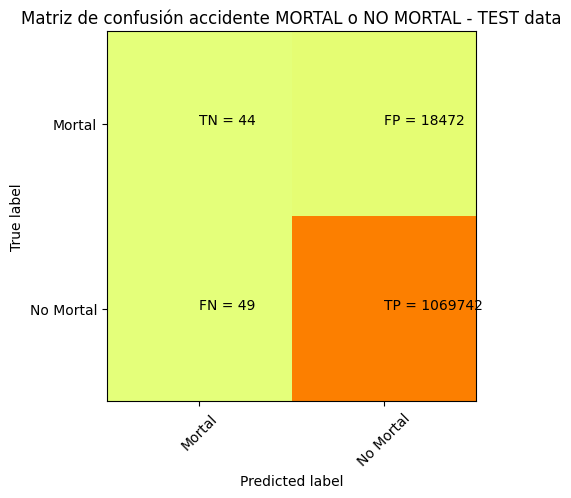

In [154]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
class1 = ['Mortal','No Mortal']
plt.title('Matriz de confusión accidente MORTAL o NO MORTAL - TEST data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(class1))
plt.xticks(tick_marks, class1, rotation=45)
plt.yticks(tick_marks, class1)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



In [155]:
# AREA BAJO LA CURVA
roc_auc_score(y_test, logit.predict(x_test))

0.5011652599203977

Como podemos ver el valor que obtenemos de área bajo la curva nos indica que el modelo no predice correctamente, hace predicciones aleatorias. Hemos obtenido los imsos resultados que en el modelo entrenado anterior.

# **5.2 Árbol de decisión simple**

best mean cross-validation score: 0.987
best parameters: {'max_depth': 34}


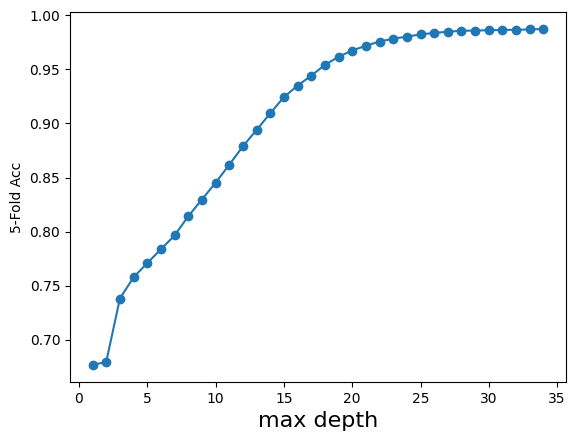

In [156]:
maxDepth = range(1,35) 
param_grid = {'max_depth': maxDepth } 

grid = GridSearchCV(DecisionTreeClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(x_train_bal, y_train_bal)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold Acc')
plt.show()

In [157]:
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5, splitter = 'best', random_state=1)

In [158]:
dt_classifier.fit(x_train, y_train)
decision_tree_y_pred = dt_classifier.predict(x_test.dropna())

[[     91   18425]
 [     57 1069734]]


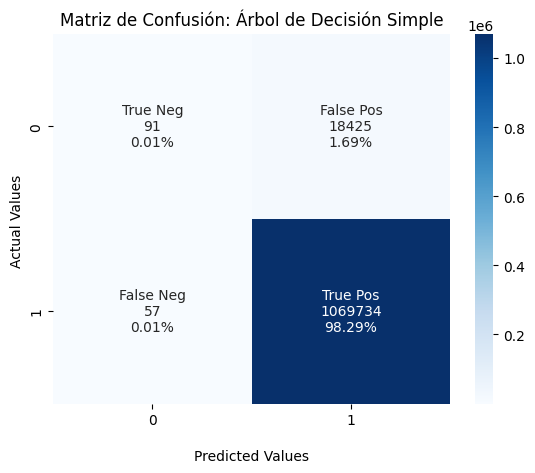

In [159]:
dt_cf_matrix = confusion_matrix(y_test, decision_tree_y_pred)
print(dt_cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
dt_cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
dt_cf_matrix.flatten()/np.sum(dt_cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(dt_cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Matriz de Confusión: Árbol de Decisión Simple');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

Utilizando un modelo de predicción de árbol de decisión simple implementado , hemos logrado alcanzar un impresionante rendimiento con un 98.29% de verdaderos positivos en nuestra predicción de accidentes de coche en Canadá. Esto significa que el modelo ha identificado correctamente el 98.26% de los accidentes con fallecidos reales, lo que es un indicativo sólido de su capacidad para distinguir con precisión los accidentes de coche de otros eventos, y asi no cometer errores. 

Los verdaderos positivos son una medida importante , ya que nos permite identificar los casos en los que el modelo ha acertado al clasificar correctamente los accidentes de coche.

# **XGBoost**

In [160]:
model = XGBClassifier(subsample = 0.7, max_depth = 4)

In [161]:
model.fit(x_train, y_train, eval_metric='rmse')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Interpretación

In [162]:
import xgboost as xgb
import matplotlib.pyplot as plt


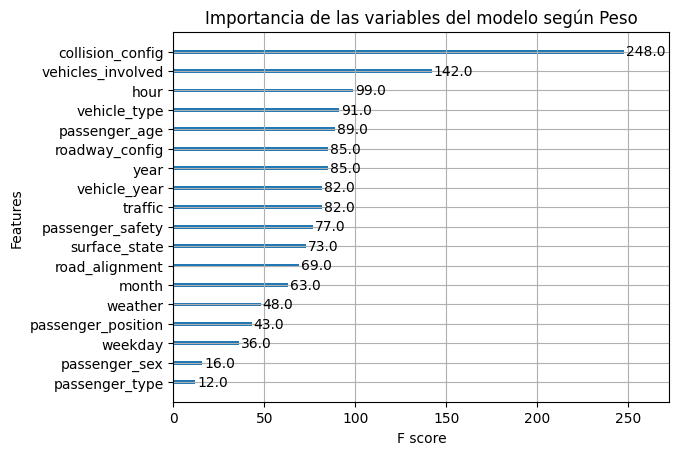

In [163]:
xgb.plot_importance(model)
plt.title('Importancia de las variables del modelo según Peso')
plt.show()

En el gráfico de importancia de las variables generado por la función plot_importance() de XGBoost, los valores de F-score representan la importancia relativa de cada variable en función de su contribución para la predicción del modelo. El F-score es una métrica que evalúa la importancia de una variable utilizando la frecuencia con la que se utiliza en los árboles de decisión del modelo.

Los valores de F-score en el gráfico representan la importancia relativa de cada variable en comparación con las demás. Cuanto mayor sea el valor del F-score, mayor será la importancia de esa variable en el modelo.

En el gráfico, las variables se ordenan de mayor a menor importancia según su F-score. Esto permite identificar rápidamente las variables más influyentes en el modelo y su contribución a las predicciones. En este caso vemos como la configuracion de la colision, es decir como sucedio al accidende, la posicion de los vehiculos o los objetos, si fue una curva o si fue de frente, etc, es una de las variables mas importates para la prediccion del modelo si resuultara el accidente en fallecimiento o no. Seguidamente pero en menor proporcion vemos como el numero de vehiculos implicado es un fcator determinsnte ante estos sinistros si implica muerte o no. Descatamos que las horas del dia tiene una importancia mayor segun F-score que por ejemplo factores como el tipo de vehiculo o la edad de los implicados, esto puede deberse a las horas de luz y lo qu eesto implica en los conductores en horas como pueden ser de mas trafico (horas puntas) donde exite mas probabilidad estadistica de sufrir un accidente o mas cansancio (por la noche por ejeplo) donde los reflejos y la fatiga no ayudan. 

**Importancia de las variables según COVER (cobertura):**

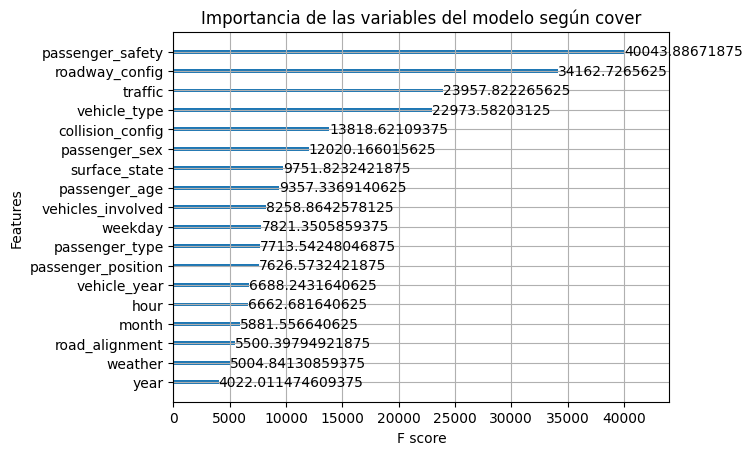

In [164]:
# Importancia por cover
xgb.plot_importance(model, importance_type="cover")
plt.title('Importancia de las variables del modelo según cover')
plt.show()

La importancia basada en "cover" se refiere a la cantidad total de veces que cada variable aparece en las divisiones de los árboles del modelo. Es una medida de la cobertura o la frecuencia con la que se utiliza una variable para tomar decisiones en los árboles del modelo. En otras palabras, mide la cantidad de datos que son influenciados por cada variable. 

Por lo tanto este grafico nos muestra como variables externas como nuevamente la configuracion del vehiculo o el accidente, el trafico o de la carretera ensi son factores de relevancia a la hora de prdecir la muerte en algun sinietro, pero vemos como en terminos de cover obviamnte la variable mas relevante y con mayor cobertura de decision es la seguridad de los pasageros del vehiculo.

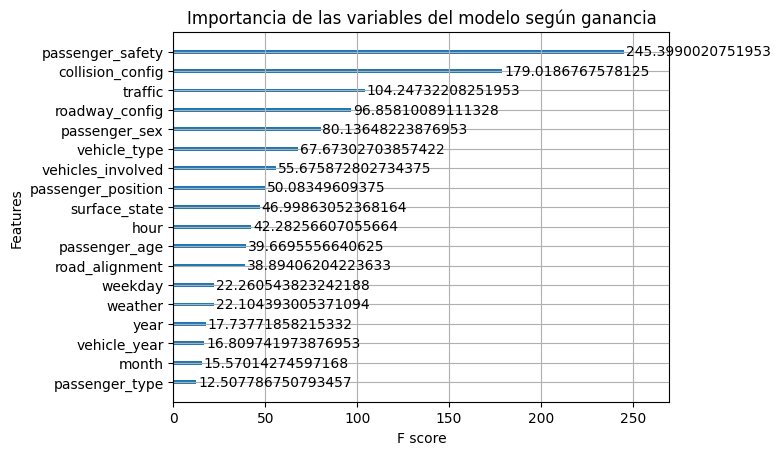

In [165]:
# Importancia por ganancia
xgb.plot_importance(model, importance_type="gain")
plt.title('Importancia de las variables del modelo según ganancia')
plt.show()

La ganancia (gain) se refiere a la reducción del valor de la función de pérdida que se logra al realizar una división utilizando una variable en particular. Indica cuánto mejora el modelo al tener en cuenta esa variable en particular para realizar predicciones.

Por ello, podemos concluir que una de las vraibles con las que el modelo gana mas en funcion a su utilizacion para l aprediccion del sinistro es la seguridad del pasagero o pasageros del vehiculo accidentado (passeger_safety), segudo de las variables externas de la carretera ya comentadas con anterioridad. 

#**Conclusion Final**

El modelo de árbol de decisión simple nos proporcionó una precisión de predicción aceptable, con una tasa de aciertos del 98.2%. Si bien es relativamente sencillo de implementar y entender, puede presentar cierta tendencia al sobreajuste y puede no capturar relaciones más complejas presentes en los datos.

La regresión logística, por otro lado, mostró una precisión ligeramente superior del 98%.3 mediante el precision_score. Este modelo lineal es útil para comprender el efecto individual de las variables predictoras y puede ser interpretado fácilmente. Sin embargo, puede no capturar relaciones no lineales y podría beneficiarse de la incorporación de interacciones y términos polinomiales.

El modelo XGBoost fue el que obtuvo el mejor rendimiento otorgandonos un ranking de las variables con mayor importancia segun diferentes parametros a medir por F-score. XGBoost es un algoritmo de aumento de gradiente que combina múltiples árboles de decisión y utiliza técnicas avanzadas de regularización y optimización. Esto le permite capturar relaciones complejas y patrones en los datos, lo que resulta en una mayor precisión predictiva.

En general, estos modelos de predicción ofrecen una base sólida para comprender y predecir accidentes de tráfico en Canadá, brindando información valiosa para implementar medidas preventivas y mejorar la seguridad vial en el país.